In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans
from sklearn.exceptions import ConvergenceWarning
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.mixture import GaussianMixture


# Suppress warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Read Excel file
data = pd.read_csv('mental-heath-in-tech-2016_20161114.csv')

# Create a DataFrame
df = pd.DataFrame(data)


##Data Preprocessing
# Remove duplicate rows
df.drop_duplicates(inplace=True)


# Remove self-employed people (it is assumed the value 1) as they are not working for the company and beyond the scope of the analysis
df = df[df['Are you self-employed?'] != 1]
df.drop('Are you self-employed?', axis=1, inplace=True)

# Drop columns that are related to being self-employed people
columns_to_drop_SE = [
    'Do you have medical coverage (private insurance or state-provided) which includes treatment of \xa0mental health issues?',
    'Do you know local or online resources to seek help for a mental health disorder?',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to clients or business contacts?',
    'If you have revealed a mental health issue to a client or business contact, do you believe this has impacted you negatively?',
    'If you have been diagnosed or treated for a mental health disorder, do you ever reveal this to coworkers or employees?',
    'If you have revealed a mental health issue to a coworker or employee, do you believe this has impacted you negatively?',
    'Do you believe your productivity is ever affected by a mental health issue?',
    'If yes, what percentage of your work time (time performing primary or secondary job functions) is affected by a mental health issue?'
]

df = df.drop(columns=columns_to_drop_SE)


# Employee count: 
# Calculate the mode
mode_value = df['How many employees does your company or organization have?'].mode()[0]

# Fill missing values with the mode using 'loc'
df.loc[df[
    'How many employees does your company or organization have?'].isnull(), 'How many employees does your company or organization have?'] = mode_value


# Tech company or not: 
# Calculate the mode
mode_value = df['Is your employer primarily a tech company/organization?'].mode()[0]

# Fill missing values with the mode using 'loc'
df.loc[df[
    'Is your employer primarily a tech company/organization?'].isnull(), 'Is your employer primarily a tech company/organization?'] = mode_value

# We assume 0 means not a tech company, which we are not interested in. Therefore, we remove rows where 'Is your employer primarily a tech company/organization?' is 0 or NaN.
df = df[(df['Is your employer primarily a tech company/organization?'] != 0) & (
    ~df['Is your employer primarily a tech company/organization?'].isnull())]
df.drop('Is your employer primarily a tech company/organization?', axis=1, inplace=True)

# Drop this column, because when only tech companies are chosen, most of the answers are NaN.
df = df.drop('Is your primary role within your company related to tech/IT?', axis=1)


# Knowledge of mental health benefits:
# Calculate the mode
mode_value = \
df['Do you know the options for mental health care available under your employer-provided coverage?'].mode()[0]

# Fill missing values with the mode
df['Do you know the options for mental health care available under your employer-provided coverage?'] = df[
    'Do you know the options for mental health care available under your employer-provided coverage?'].fillna(
    mode_value)


# Drop columns that are about previous and future employment, and familial history or information
columns_to_drop_PE = [
    'Do you have a family history of mental illness?',
    'Would you bring up a mental health issue with a potential employer in an interview?',
    'Why or why not?.1',
    'How willing would you be to share with friends and family that you have a mental illness?',
    'Have your previous employers provided mental health benefits?',
    'Were you aware of the options for mental health care provided by your previous employers?',
    'Did your previous employers ever formally discuss mental health (as part of a wellness campaign or other official communication)?',
    'Did your previous employers provide resources to learn more about mental health issues and how to seek help?',
    'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?',
    'Do you think that discussing a mental health disorder with previous employers would have negative consequences?',
    'Do you think that discussing a physical health issue with previous employers would have negative consequences?',
    'Would you have been willing to discuss a mental health issue with your previous co-workers?',
    'Would you have been willing to discuss a mental health issue with your direct supervisor(s)?',
    'Did you feel that your previous employers took mental health as seriously as physical health?',
    'Did you hear of or observe negative consequences for co-workers with mental health issues in your previous workplaces?',
    'If maybe, what condition(s) do you believe you have?'
]

df = df.drop(columns=columns_to_drop_PE)

# Drop columns about the diagnosis of physician and 'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?' because half of it are  missing values. Also questions about physical health, since we mostly want to talk about mental health.
columns_to_drop_PH = [
    'If so, what condition(s) were you diagnosed with?',
    'Have your observations of how another individual who discussed a mental health disorder made you less likely to reveal a mental health issue yourself in your current workplace?',
    'Do you think that discussing a physical health issue with your employer would have negative consequences?',
    'Would you be willing to bring up a physical health issue with a potential employer in an interview?',
    'Why or why not?'
]

df = df.drop(columns=columns_to_drop_PH)


# Drop columns that describe the country of residence because it is the same as country of employment. Also, drop the columns that are about US States of residence because there was only one outlier that live and work in different states. 
columns_to_drop_loc = [
    'What country do you live in?',
    'What US state or territory do you live in?'
]

df = df.drop(columns=columns_to_drop_loc)


# Filter rows where 'What country do you work in?' is 'United States of America' to limit scope and retain majority of data points. Then drop the column.
df = df[df['What country do you work in?'] == 'United States of America']
df.drop('What country do you work in?', axis=1, inplace=True)

# Reset index after filtering
df.reset_index(drop=True, inplace=True)


# Observed negatively handled mental health issue: 
# Calculate the mode
mode_value = df[
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?'].mode()[
    0]

# Fill missing values with the mode
df[
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?'] = \
df[
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?'].fillna(
    mode_value)


# Work position:
# Split multiple positions into separate columns
positions = df['Which of the following best describes your work position?'].str.get_dummies('|')

# Add prefixes to the new columns
positions = positions.add_prefix('Pos_')

df = pd.concat([df, positions], axis=1)

# Group "Other" and "One-person shop" into a broader "Other" category
df['Which of the following best describes your work position?'] = df[
    'Which of the following best describes your work position?'].replace(['Other', 'One-person shop'], 'Other')

# Fill missing values with "Unknown"
df['Which of the following best describes your work position?'] = df[
    'Which of the following best describes your work position?'].fillna('Unknown')

# Consolidate similar positions (e.g., "DevOps/SysAdmin" and "Supervisor/Team Lead" into "Management")
df['Which of the following best describes your work position?'] = df[
    'Which of the following best describes your work position?'].replace(['DevOps/SysAdmin', 'Supervisor/Team Lead'],
                                                                         'Management')
# Drop original 'WorkPosition' column if new columns were created
df = df.drop('Which of the following best describes your work position?', axis=1)


# Current mental health diagnoses:
# Replace missing values with "No Diagnosis" as a placeholder
df['If yes, what condition(s) have you been diagnosed with?'] = df['If yes, what condition(s) have you been diagnosed with?'].fillna('No Diagnosis')

# Split the multiple diagnoses into separate columns
diagnoses = df['If yes, what condition(s) have you been diagnosed with?'].str.get_dummies('|')

# Add prefixes to the new columns
diagnoses = diagnoses.add_prefix('Diag_')

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, diagnoses], axis=1)

# Drop the original column
df.drop('If yes, what condition(s) have you been diagnosed with?', axis=1, inplace=True)


In [2]:
#Feature engineering: 
# Encoding
# One-hot encode 'Do you work remotely?'
df_encoded_rw = pd.get_dummies(df, columns=['Do you work remotely?'], prefix='remote')

# Convert boolean columns to integers (0 or 1)
df_encoded_rw['remote_Always'] = df_encoded_rw['remote_Always'].astype(int)
df_encoded_rw['remote_Never'] = df_encoded_rw['remote_Never'].astype(int)
df_encoded_rw['remote_Sometimes'] = df_encoded_rw['remote_Sometimes'].astype(int)

# Assign the one-hot encoded columns back to df
df = pd.concat([df, df_encoded_rw[['remote_Always', 'remote_Never', 'remote_Sometimes']]], axis=1)

# Drop the original 'Do you work remotely?' column
df = df.drop('Do you work remotely?', axis=1)


In [3]:
# Define a mapping dictionary for columns with these answers:
mapping = {'No': 0, 'Yes': 1, 'I don\'t know': 2, 'Not eligible for coverage / N/A': 3}

# Map the values using the dictionary
df['Does your employer provide mental health benefits as part of healthcare coverage?'] = df['Does your employer provide mental health benefits as part of healthcare coverage?'].replace(mapping)

df['Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?'] = df['Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?'].replace(mapping)

df['Does your employer offer resources to learn more about mental health concerns and options for seeking help?'] = df['Does your employer offer resources to learn more about mental health concerns and options for seeking help?'].replace(mapping)

df['Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?'] = df['Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?'].replace(mapping)

df['Do you feel that your employer takes mental health as seriously as physical health?'] = df['Do you feel that your employer takes mental health as seriously as physical health?'].replace(mapping)

df['Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?'] = df['Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?'].replace(mapping)

df['Have you been diagnosed with a mental health condition by a medical professional?'] = df['Have you been diagnosed with a mental health condition by a medical professional?'].replace(mapping)


# Define a mapping dictionary for columns with these answers:
mapping = {'No': 0, 'Yes': 1, 'I am not sure': 2}

# Map the values using the dictionary
df['Do you know the options for mental health care available under your employer-provided coverage?'] = df['Do you know the options for mental health care available under your employer-provided coverage?'].replace(mapping)


# Define a mapping dictionary for columns with these answers:
mapping = {'No': 0, 'Yes': 1, 'Maybe': 2}

# Map the values using the dictionary
df['Do you think that discussing a mental health disorder with your employer would have negative consequences?'] = df[
    'Do you think that discussing a mental health disorder with your employer would have negative consequences?'].replace(mapping)

df[
    'Would you feel comfortable discussing a mental health disorder with your coworkers?'] = \
    df[
        'Would you feel comfortable discussing a mental health disorder with your coworkers?'].replace(
        mapping)

df['Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?'] = df[
    'Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?'].replace(
    mapping)

df[
    'Have you had a mental health disorder in the past?'] = \
    df[
        'Have you had a mental health disorder in the past?'].replace(
        mapping)

df['Do you currently have a mental health disorder?'] = df[
    'Do you currently have a mental health disorder?'].replace(mapping)


# Define a mapping dictionary for columns with these answers:
mapping = {'I don\'t know': 0, 'Very difficult': 1, 'Somewhat difficult': 2, 'Neither easy nor difficult': 3, 'Somewhat easy': 4, 'Very easy': 5}

# Map the values using the dictionary
df['If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:'] = df[
    'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:'].replace(mapping)


# Define a mapping dictionary for columns with these answers:
mapping = {'No, it has not': 0, 'No, I don\'t think it would': 1, 'Maybe': 2, 'Yes, I think it would': 3, 'Yes, it has': 4}

# Map the values using the dictionary
df['Do you feel that being identified as a person with a mental health issue would hurt your career?'] = df[
    'Do you feel that being identified as a person with a mental health issue would hurt your career?'].replace(mapping)


# Define a mapping dictionary for columns with these answers:
mapping = {'No, they do not': 0, 'No, I don\'t think they would': 1, 'Maybe': 2, 'Yes, I think they would': 3, 'Yes, they do': 4}

# Map the values using the dictionary
df['Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?'] = df[
    'Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?'].replace(mapping)


# Define a mapping dictionary for columns with these answers:
mapping = {'Maybe/Not sure': 0, 'No': 1, 'Yes, I observed': 2, 'Yes, I experienced': 3}

# Map the values using the dictionary
df['Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?'] = df[
    'Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?'].replace(mapping)


# Define a mapping dictionary for columns with these answers:
mapping = {'Not applicable to me': 0, 'Never': 1, 'Rarely': 2, 'Sometimes': 3, 'Often': 4}

# Map the values using the dictionary
df['If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'] = df[
    'If you have a mental health issue, do you feel that it interferes with your work when being treated effectively?'].replace(mapping)

df['If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'] = df[
    'If you have a mental health issue, do you feel that it interferes with your work when NOT being treated effectively?'].replace(mapping)


In [4]:
# Size of Company: 
# One-hot encode the 'How many employees does your company or organization have?' column
company_encoded = pd.get_dummies(df['How many employees does your company or organization have?'], prefix='com_size', drop_first=False)

# Convert one-hot encoded values to integers
company_encoded = company_encoded.astype(int)

# Drop the original 'How many employees does your company or organization have?' column
df = df.drop('How many employees does your company or organization have?', axis=1)

# Concatenate the encoded values back to the original DataFrame
df_encoded = pd.concat([df, company_encoded], axis=1)


# Gender: 
# Replace variations of 'male' with 'Male'
df['What is your gender?'] = df['What is your gender?'].replace(
    ['m', 'man', 'male (cis)', 'cis male', 'cis man', 'cisdude', 'Dude', 'malr', 'mail', 'cis man', 'I\'m a man why didn\'t you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ', 'Sex is male',
     'm|', 'male.', 'male '], 'Male')

# Replace variations of 'female' with 'Female'
df['What is your gender?'] = df['What is your gender?'].replace(
    ['afab','f', 'F', 'I identify as female.', 'fem', 'woman', 'cis female', 'Cis female','Cisgender Female', 'Cis-woman', 'cis-woman', 'female (cis)',
     'femake', 'female (cis)', 'female ', 'woman-identified',' Female', 'Female (props for making this a freeform field, though)'
     'female-bodied; no feelings about gender', 'Female assigned at birth', 'Female or Multi-Gender Femme', 'female/woman',
     'female '], 'Female')

# Assign all other entries to 'Other'
df['What is your gender?'] = df['What is your gender?'].apply(lambda x: 'Other' if x not in ['Male', 'Female'] else x)

# One-hot encode the 'What is your gender?' column
gender_encoded = pd.get_dummies(df['What is your gender?'], prefix='gender', drop_first=False)

# Convert one-hot encoded values to integers
gender_encoded = gender_encoded.astype(int)

# Drop the original 'What is your gender?' column
df = df.drop('What is your gender?', axis=1)

# Concatenate the encoded values back to the original DataFrame
df_encoded = pd.concat([df, gender_encoded], axis=1)

df_encoded


,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,...,Diag_Sexual addiction,Diag_Stress Response Syndromes,Diag_Substance Use Disorder,Diag_Traumatic Brain Injury,remote_Always,remote_Never,remote_Sometimes,gender_Female,gender_Male,gender_Other
0,0,1,1,1,1,4,0,2,1,1,...,0,0,0,0,0,1,0,0,0,1
1,2,0,0,0,2,4,0,2,1,1,...,0,0,0,0,0,0,1,0,0,1
2,1,1,0,1,1,5,0,2,1,2,...,0,0,1,0,1,0,0,0,0,1
3,1,2,1,1,1,5,0,2,1,1,...,0,0,0,0,0,1,0,0,1,0
4,1,2,0,0,1,5,0,1,1,1,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0,0,0,0,2,4,2,0,2,2,...,0,0,0,0,0,1,0,0,1,0
543,1,1,1,1,1,4,2,1,0,0,...,0,0,0,0,0,0,1,0,0,1
544,2,2,0,2,2,0,2,2,2,2,...,0,0,0,0,1,0,0,0,0,1
545,1,0,0,0,1,4,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1


In [5]:
# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the US state of employment
df_encoded['What US state or territory do you work in?'] = label_encoder.fit_transform(df_encoded['What US state or territory do you work in?'])

In [6]:
#Age: 
# Replace extreme values by capping
max_age = 66
df_encoded['What is your age?'] = [age if age < max_age else max_age for age in df_encoded['What is your age?']]

def get_generation(age):
    if age < 29:
        return "Gen Z"
    elif age < 44:
        return "Millennials"
    elif age < 59:
        return "Gen X"
    else:
        return "Boomers"

df_encoded['Age_Group'] = [get_generation(age) for age in df_encoded['What is your age?']]

# One-hot encode the 'Age_Group' column
age_group_dummies = pd.get_dummies(df_encoded['Age_Group'], prefix='age', drop_first=False)

# Convert one-hot encoded values to integers
age_group_dummies = age_group_dummies.astype(int)

# Concatenate the one-hot encoded columns with the original DataFrame
df_encoded = pd.concat([df_encoded, age_group_dummies], axis=1)

# Drop the original 'Age_Group' column as it's no longer needed
df_encoded.drop('Age_Group', axis=1, inplace=True)
df_encoded.drop('What is your age?', axis=1, inplace=True)

df_encoded


,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:",Do you think that discussing a mental health disorder with your employer would have negative consequences?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?,Do you feel that your employer takes mental health as seriously as physical health?,...,remote_Always,remote_Never,remote_Sometimes,gender_Female,gender_Male,gender_Other,age_Boomers,age_Gen X,age_Gen Z,age_Millennials
0,0,1,1,1,1,4,0,2,1,1,...,0,1,0,0,0,1,0,0,0,1
1,2,0,0,0,2,4,0,2,1,1,...,0,0,1,0,0,1,0,0,0,1
2,1,1,0,1,1,5,0,2,1,2,...,1,0,0,0,0,1,0,0,0,1
3,1,2,1,1,1,5,0,2,1,1,...,0,1,0,0,1,0,0,0,1,0
4,1,2,0,0,1,5,0,1,1,1,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,0,0,0,0,2,4,2,0,2,2,...,0,1,0,0,1,0,0,0,1,0
543,1,1,1,1,1,4,2,1,0,0,...,0,0,1,0,0,1,0,0,0,1
544,2,2,0,2,2,0,2,2,2,2,...,1,0,0,0,0,1,0,0,0,1
545,1,0,0,0,1,4,0,1,1,1,...,1,0,0,0,0,1,0,0,0,1


In [7]:
## Feature Selection
# Chi2 feature selection
# Separate features (X) and target variable (y)
X = df_encoded  # Use all features 
y = df_encoded['Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?']  

# Number of features
k = 3

# Apply SelectKBest class to extract top k best features using chi2
best_features = SelectKBest(score_func=chi2, k=k)
fit = best_features.fit(X, y)

# Create a DataFrame with the scores and feature names
dfscores = pd.DataFrame(fit.scores_)
dfpvalues = pd.DataFrame(fit.pvalues_)
dfcolumns = pd.DataFrame(X.columns)
feature_scores = pd.concat([dfcolumns, dfscores, dfpvalues], axis=1)
feature_scores.columns = ['Feature', 'Score', 'P-value']

# Get the top k features
top_features = feature_scores.nlargest(k, 'Score')
selected_features = top_features['Feature'].tolist()

# Print("Selected Features:")
print(selected_features)
print("\nTop Feature Scores and P-values:")
print(top_features)

['Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?', 'Do you think that discussing a mental health disorder with your employer would have negative consequences?', 'If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:']

Top Feature Scores and P-values:
                                             Feature       Score       P-value
8  Would you feel comfortable discussing a mental...  320.177391  2.981006e-70
6  Do you think that discussing a mental health d...  102.437642  5.700970e-23
5  If a mental health issue prompted you to reque...   99.860595  2.067985e-22


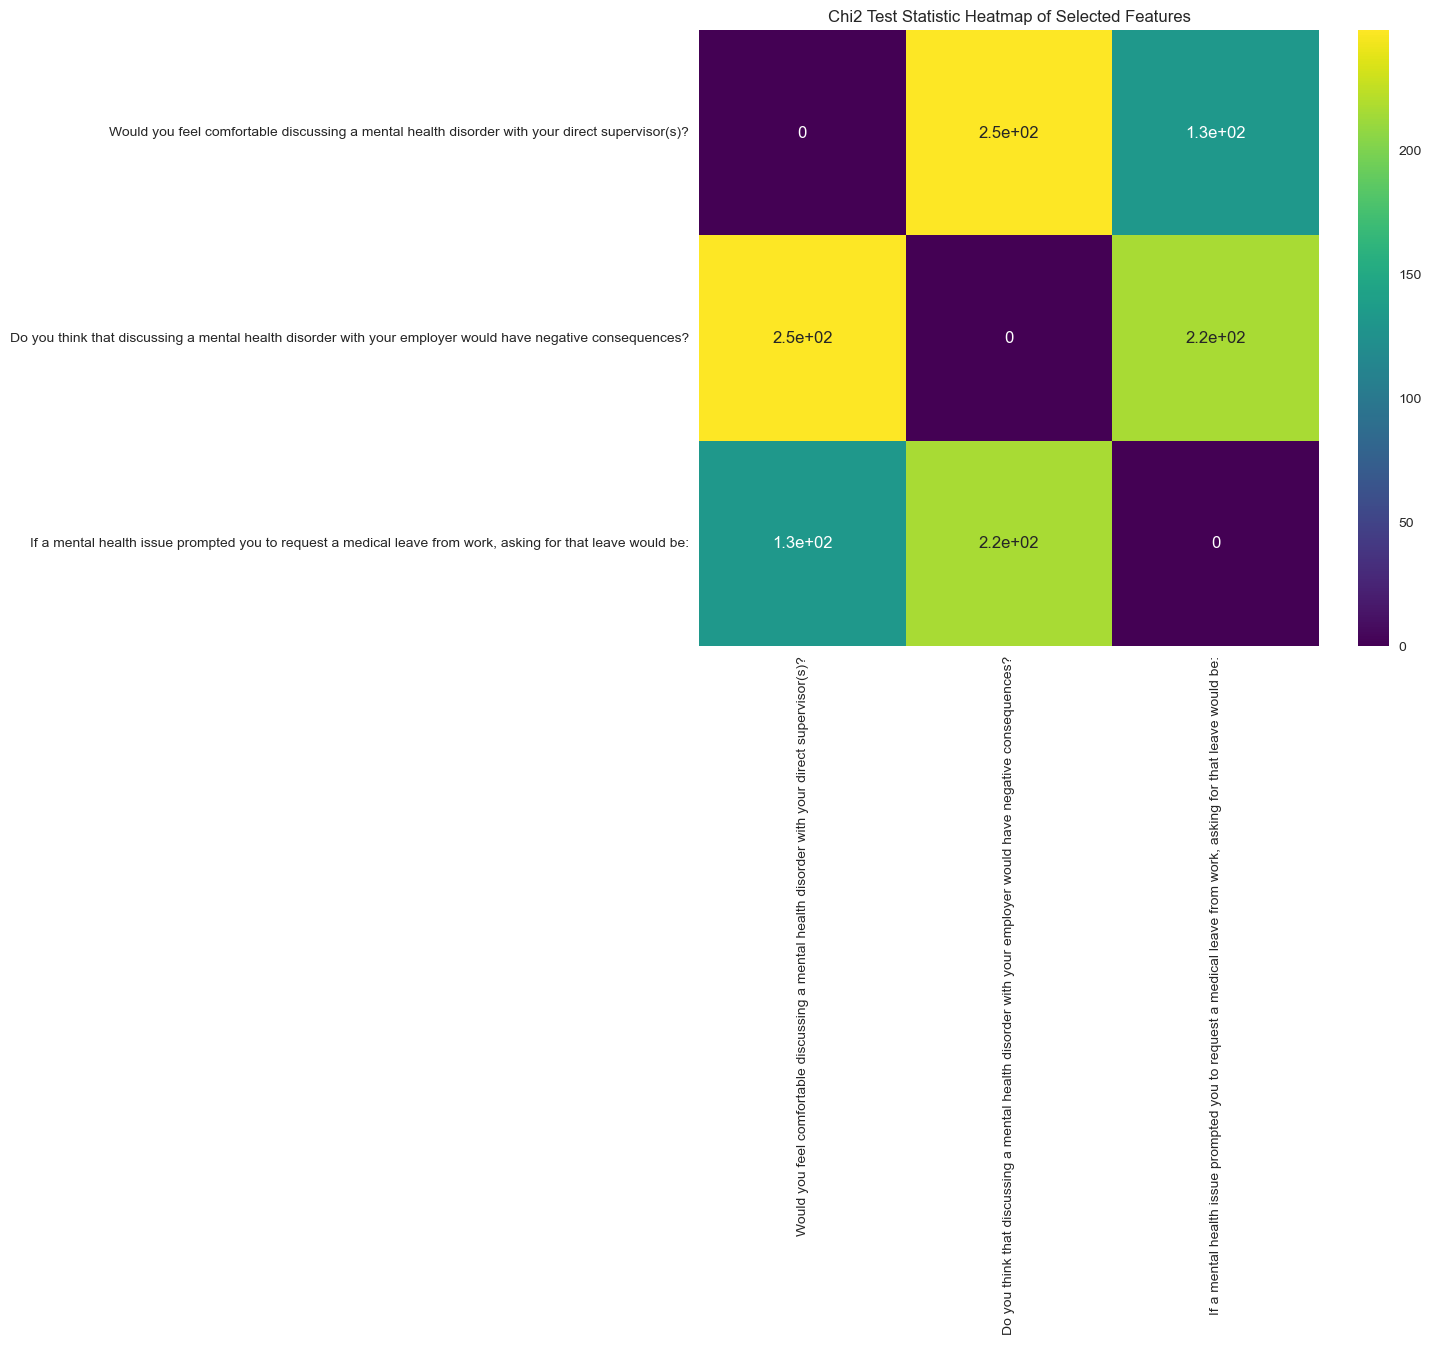

In [8]:
# Compute chi2 matrix for selected features
selected_features_df = X[selected_features]
def chi2_matrix(data):
    p_values = pd.DataFrame(index=data.columns, columns=data.columns)
    for i in data.columns:
        for j in data.columns:
            if i == j:
                p_values.loc[i, j] = 0.0
                continue
            observed = pd.crosstab(data[i], data[j])
            chi2, _, _, _ = chi2_contingency(observed)
            p_values.loc[i, j] = chi2
    return p_values.astype(float)

chi2_matrix_df = chi2_matrix(selected_features_df)

# Create a heatmap for chi2 results
plt.figure(figsize=(10, 8))
sns.heatmap(chi2_matrix_df, annot=True, cmap='viridis')
plt.title('Chi2 Test Statistic Heatmap of Selected Features')
plt.show()

MCA Results:
    Component 1   Component 2
0 -7.180591e-16  5.898471e-14
1 -1.497929e-19  7.232587e-18
2  7.676539e-02  2.427893e-03
3  7.676539e-02  2.427893e-03
4  7.676539e-02  2.427893e-03


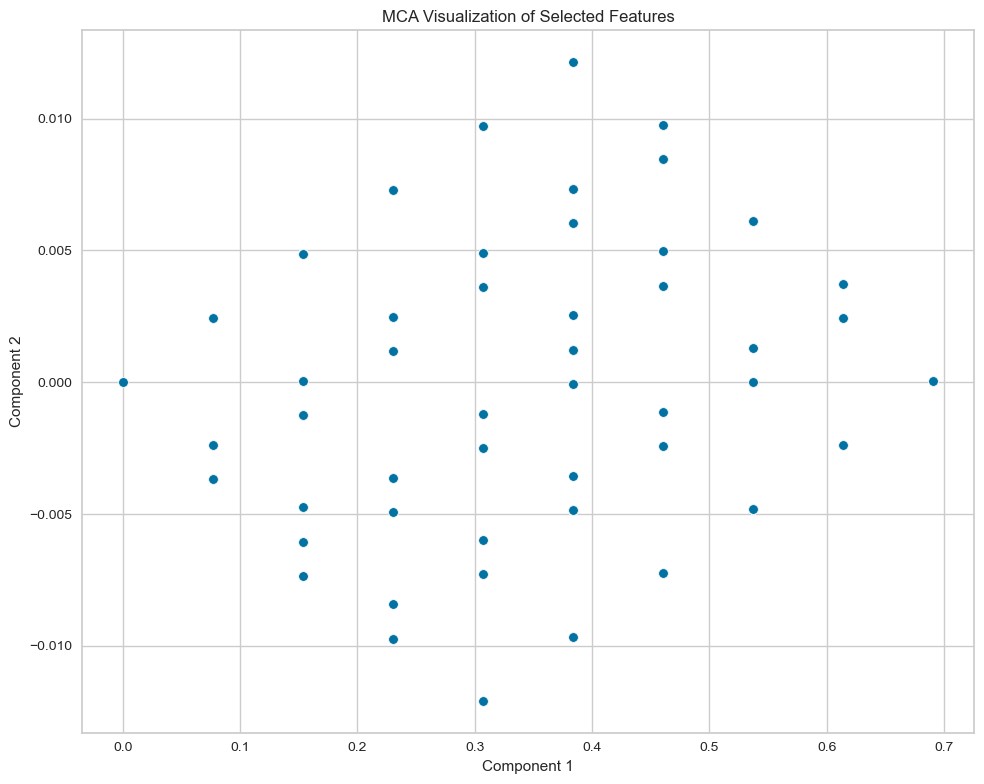

In [9]:
## Feature reduction: MCA
# Convert selected features to categorical type
selected_features_df = df_encoded[selected_features].astype('category')

# Create a matrix of categories (dummy variables)
categories = selected_features_df.apply(lambda x: pd.factorize(x)[0])

# Calculate the row and column masses
row_masses = categories.sum(axis=1)
col_masses = categories.sum(axis=0)

# Total mass
total_mass = row_masses.sum()

# Expected frequencies under independence assumption
expected = np.outer(row_masses.values, col_masses.values) / total_mass

# Observed frequencies
observed = categories.values / total_mass

# Symmetric matrix of residuals
residuals = observed - expected

# Singular Value Decomposition (SVD) of residuals
U, D, Vt = np.linalg.svd(residuals, full_matrices=False)

# Components
components = U * np.sqrt(D)

# Coordinates of rows and columns
row_coordinates = components[:, :2]
col_coordinates = Vt.T[:, :2]

# Create a DataFrame for the MCA results
mca_df = pd.DataFrame(data=row_coordinates, columns=['Component 1', 'Component 2'])

# Print out MCA results
print("MCA Results:")
print(mca_df.head())

# Visualize the MCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component 1', y='Component 2', data=mca_df)
plt.title('MCA Visualization of Selected Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()


C:\Users\Monique\anaconda3\envs\Tech_MentalHealth\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Monique\anaconda3\envs\Tech_MentalHealth\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Monique\anaconda3\envs\Tech_MentalHealth\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Monique\anaconda3\envs\Tech_MentalHealth\lib\site-pa

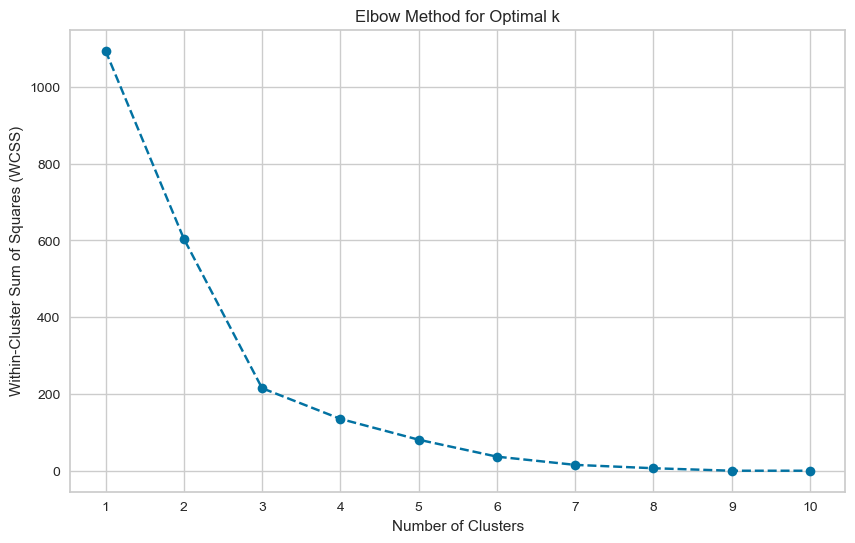

C:\Users\Monique\anaconda3\envs\Tech_MentalHealth\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


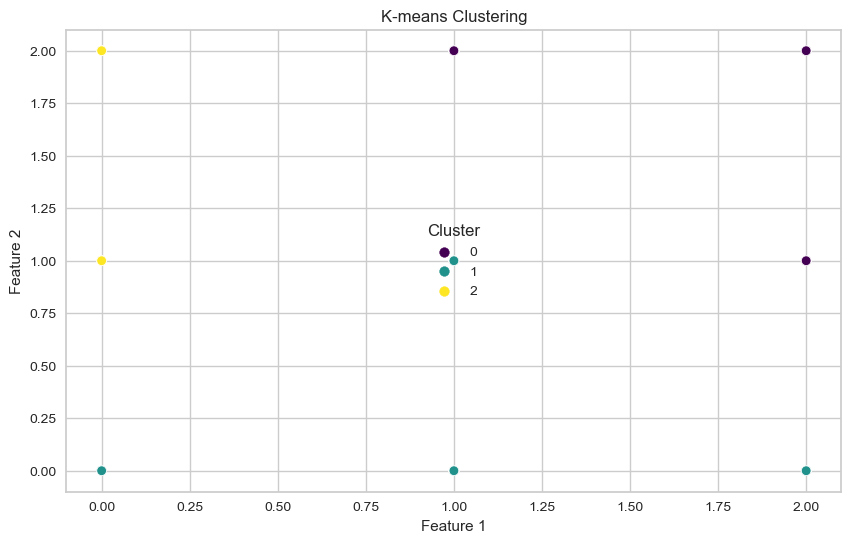

The average silhouette_score is : 0.6847819157507525


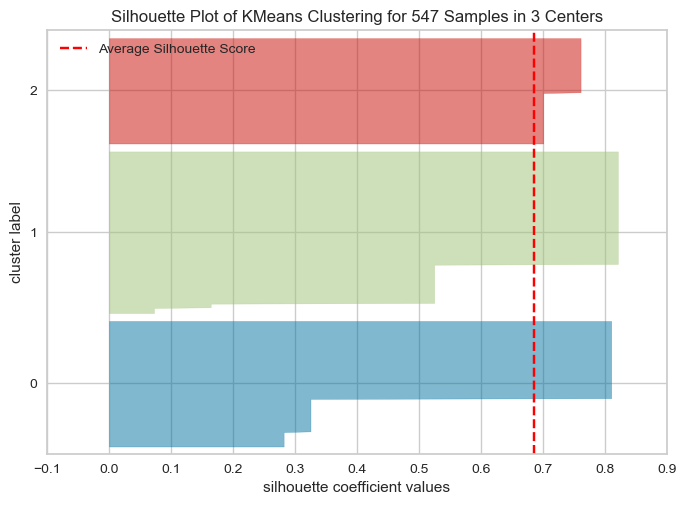

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 547 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [10]:
## Clustering
# Select the top features for clustering
X_cluster = df_encoded[['Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
                        'Do you think that discussing a mental health disorder with your employer would have negative consequences?']]

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_cluster)


# K-Means: 
# Performing Elbow Curve to find optimal K
# Calculate the within-cluster sum of squares for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_normalized)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()


# Set n_init to suppress FutureWarning
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)

# K-means clustering
n_clusters = 3  

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_normalized)

# Add the 'Cluster' column to the original dataframe
df_encoded['Cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_encoded, x='Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
                y='Do you think that discussing a mental health disorder with your employer would have negative consequences?',
                hue='Cluster', palette='viridis', legend='full')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_normalized, kmeans.labels_)
print("The average silhouette_score is :", silhouette_avg)

# Create the silhouette score visualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

# Fit and display the visualizer
visualizer.fit(X_normalized)  
visualizer.show()  


# GMM Clustering: 
# Calculate the Bayesian Information Criterion (BIC) for different values of k
#bic = []
#for k in range(1, 11):
#    gmm = GaussianMixture(n_components=k, random_state=42)
#    gmm.fit(X_normalized)
#    bic.append(gmm.bic(X_normalized))

# Plot the BIC curve
#plt.figure(figsize=(10, 6))
#plt.plot(range(1, 11), bic, marker='o', linestyle='--')
#plt.xlabel('Number of Components')
#plt.ylabel('Bayesian Information Criterion (BIC)')
#plt.title('BIC for Optimal Number of Components')
#plt.xticks(np.arange(1, 11, 1))
#plt.grid(True)
#plt.show()

# Choose the number of clusters based on the BIC curve
# Gaussian Mixture Model clustering
#n_components = 3 # From the plot, 3 is the number of clusters where BIC is lowest

#gmm = GaussianMixture(n_components=n_components, random_state=42)
#gmm.fit(X_normalized)

# Predict the cluster labels
#cluster_labels = gmm.predict(X_normalized)

# Add the 'Cluster' column to the original dataframe
#df_encoded['Cluster'] = cluster_labels

# Visualize the clusters
#plt.figure(figsize=(10, 6))
#sns.scatterplot(data=df_encoded, x='Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
#                y='Do you think that discussing a mental health disorder with your employer would have negative consequences?',
#                hue='Cluster', palette='viridis', legend='full')
#plt.title('Gaussian Mixture Model Clustering')
#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.show()

# Calculate the silhouette score
#silhouette_avg = silhouette_score(X_normalized, cluster_labels)
#print("The average silhouette_score is :", silhouette_avg)


# Agglomerative Clustering
#n_clusters = 3  # Number of clusters

#agg_cluster = AgglomerativeClustering(n_clusters=n_clusters)
#cluster_labels = agg_cluster.fit_predict(X_normalized)

# Add the 'Cluster' column to the original dataframe
#df_encoded['Cluster'] = cluster_labels

# Create linkage matrix
#Z = linkage(X_normalized, method='ward')

# Create dendrogram
#plt.figure(figsize=(12, 8))
#dendro = dendrogram(
#    Z,
#    truncate_mode='lastp',
#    p=30,
#    leaf_rotation=90.,
#    leaf_font_size=12.,
#    show_contracted=True,
#    show_leaf_counts=True
#)
#plt.title('Dendrogram')
#plt.xlabel('Cluster Size')
#plt.ylabel('Distance')
#plt.axhline(y=50, color='gray', linestyle='--')
#plt.show()

# Visualize the clusters
#plt.figure(figsize=(10, 6))
#sns.scatterplot(data=df_encoded, x='Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?',
#                y='Do you think that discussing a mental health disorder with your employer would have negative consequences?',
#                hue='Cluster', palette='viridis', legend='full')
#plt.title('Agglomerative Clustering')
#plt.xlabel('Feature 1')
#plt.ylabel('Feature 2')
#plt.show()

# Calculate the silhouette score
#silhouette_avg = silhouette_score(X_normalized, cluster_labels)
#print("The average silhouette_score is :", silhouette_avg)

        age_Boomers       age_Gen X       age_Millennials       age_Gen Z  \
               mean count      mean count            mean count      mean   
Cluster                                                                     
0          0.005714   175  0.102857   175        0.645714   175  0.245714   
1          0.017778   225  0.062222   225        0.648889   225  0.271111   
2          0.000000   147  0.136054   147        0.537415   147  0.326531   

              Cluster        
        count    mean count  
Cluster                      
0         175     0.0   175  
1         225     1.0   225  
2         147     2.0   147  


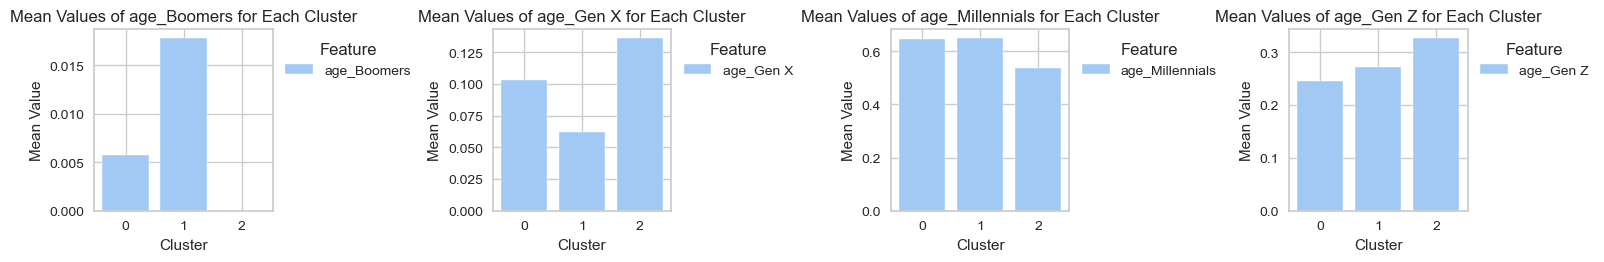

In [11]:
# Analyze demographics per cluster
features_of_interest = [
    'age_Boomers', 
    'age_Gen X',
    'age_Millennials',
    'age_Gen Z',
    #'gender_Male',  
    #'gender_Female',
    #'gender_Other', 
    #'remote_Always',  
    #'remote_Never',
    #'remote_Sometimes',
    #'Diag_ADD (w/o Hyperactivity)', 'Diag_Addictive Disorder','Diag_Anxiety Disorder (Generalized, Social, Phobia, etc)', 'Diag_Attention Deficit Hyperactivity Disorder', 
    #'Diag_Autism','Diag_Dissociative Disorder', 'Diag_Eating Disorder (Anorexia, Bulimia, etc)', 
    #'Diag_Mood Disorder (Depression, Bipolar Disorder, etc)', 'Diag_No Diagnosis', 'Diag_Obsessive-Compulsive Disorder', 
    #'Diag_PTSD (undiagnosed)', 'Diag_Personality Disorder (Borderline, Antisocial, Paranoid, etc)', 'Diag_Pervasive Developmental Disorder (Not Otherwise Specified)', 
    #'Diag_Post-traumatic Stress Disorder', 'Diag_Psychotic Disorder (Schizophrenia, Schizoaffective, etc)', 'Diag_Schizotypal Personality Disorder',
    #'Diag_Seasonal Affective Disorder', 'Diag_Sexual addiction', 'Diag_Stress Response Syndromes', 
    #'Diag_Substance Use Disorder', 'Diag_Traumatic Brain Injury',
    #'Pos_Back-end Developer', 'Pos_Designer', 'Pos_Dev Evangelist/Advocate', 'Pos_DevOps/SysAdmin', 'Pos_Executive Leadership', 'Pos_Front-end Developer', 'Pos_HR', 'Pos_One-person shop', 'Pos_Other', 'Pos_Sales', 'Pos_Supervisor/Team Lead','Pos_Support',                                                        
    'Cluster'  # The cluster labels
]

# Calculate the average values of features for each cluster
cluster_stats = df_encoded.groupby('Cluster')[features_of_interest].agg(['mean', 'count'])

# Print mean values and counts
print(cluster_stats)

# Plotting
plt.figure(figsize=(16, 12))  
sns.set_palette("pastel")

# Iterate through each feature and plot
for i, feature in enumerate(features_of_interest[:-1]):  
    plt.subplot(5, 4, i + 1) 
    plt.bar(cluster_stats.index, cluster_stats[feature]['mean'], label=feature)
    plt.xlabel('Cluster')
    plt.ylabel('Mean Value')
    plt.title(f'Mean Values of {feature} for Each Cluster')
    plt.xticks(cluster_stats.index)
    plt.legend(title='Feature', bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


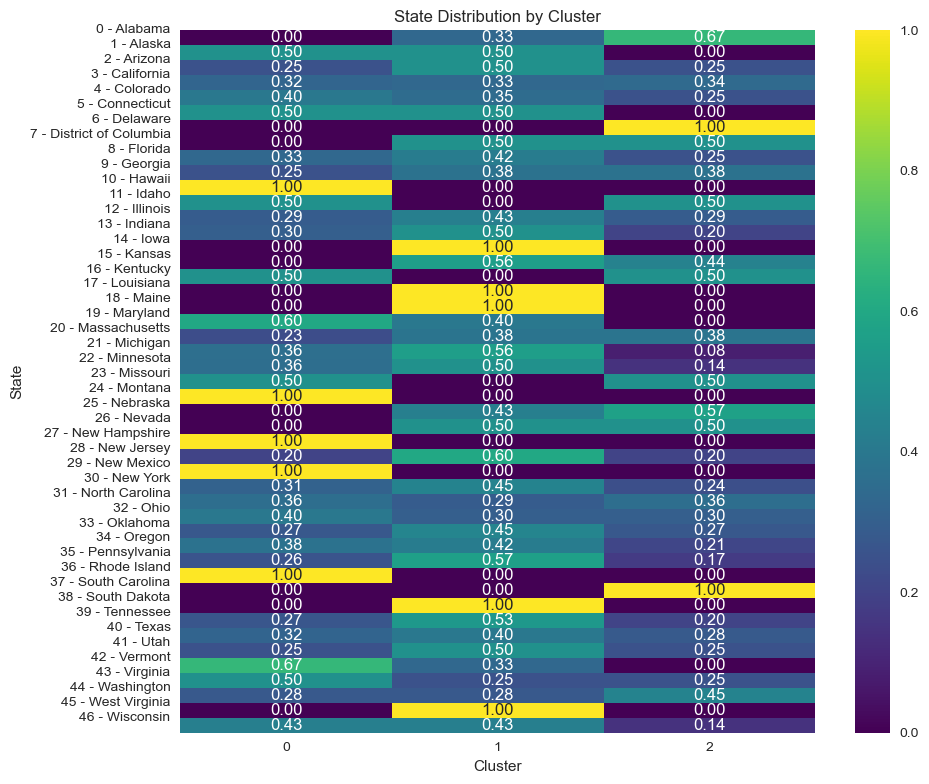

In [12]:
# State distribution by cluster 
# Create the cross-tabulation
cross_tab = pd.crosstab(df_encoded['What US state or territory do you work in?'], df_encoded['Cluster'], normalize='index')

# Get the state names
state_names = label_encoder.inverse_transform(cross_tab.index)

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, cmap='viridis', annot=True, fmt='.2f', cbar=True)
plt.title('State Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('State')

# Set y-tick labels to include both encoding and state name
plt.yticks(ticks=range(len(state_names)), labels=[f"{index} - {state}" for index, state in zip(cross_tab.index, state_names)], rotation=0)

plt.tight_layout()
plt.show()